In [2]:
import pandas as pd
import numpy as np
import kerasncp as kncp
import tensorflow  as tf
import copy
import string
import seaborn as sns
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import scipy.stats as stats
import numpy as np
import pandas as pd
from kerashypetune import KerasRandomSearch
from gensim import models
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow import keras
from kerasncp.tf import LTCCell
from sklearn.model_selection import StratifiedKFold, train_test_split
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [21]:
stfold = StratifiedKFold(n_splits=5, shuffle=True)
train_l = list()
val_l = list()
test_l = list()
maxlen = 25
cnt = 0
test_folds = {}
for train_index, test_index in stfold.split(df['comment'], df['label']):
    cnt += 1
    train = df.iloc[train_index]
    train_x, train_y = train['comment'], train['label']
    tmp = df.iloc[test_index]

    val, test = train_test_split(tmp, test_size=0.5, stratify=tmp['label'])    
    val_x, val_y = val['comment'], val['label']
    test_x, test_y = test['comment'], test['label']    
    
    train_x = keras.preprocessing.sequence.pad_sequences(train_x, maxlen=maxlen)
    val_x = keras.preprocessing.sequence.pad_sequences(val_x, maxlen=maxlen)
    test_x = keras.preprocessing.sequence.pad_sequences(test_x, maxlen=maxlen)
    
    test_folds[cnt] = (test_x, test_y)


    embed_dim = 128  # Embedding size for each token
    vocab_size = n_word_unique + 1
    wiring = kncp.wirings.NCP(
                                inter_neurons=12,  # Number of inter neurons
                                command_neurons=8,  # Number of command neurons
                                motor_neurons=1,  # Number of motor neurons
                                sensory_fanout=4,  # How many outgoing synapses has each sensory neuron
                                inter_fanout=4,  # How many outgoing synapses has each inter neuron
                                recurrent_command_synapses=4,  # Now many recurrent synapses are in the
                                # command neuron layer
                                motor_fanin=6,
                              )
    ltc_cell = LTCCell(wiring) # Create LTC model
    
    model = keras.Sequential(
        [
            keras.layers.InputLayer(input_shape=maxlen),            
            keras.layers.Embedding(input_dim = vocab_size, 
                                    output_dim = embed_dim, 
                                    input_length=maxlen),
            keras.layers.Dropout(0.2),
            keras.layers.RNN(ltc_cell, return_sequences=False),
            keras.layers.Dense(1, activation="sigmoid")

        ]
    )
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0046),
                loss="binary_crossentropy", metrics=["accuracy", tf.keras.metrics.AUC(name='auc')])

    
    
    #create checkpoint to save model
    #with best validation loss
    PATH = 'drive/Shared drives/Magdas-PROJECT/data/save_weights/ncp_no_emb'
    PATH2 = PATH + "/" + str(cnt)
    if not os.path.isdir(PATH):
      !mkdir $PATH
    !mkdir $PATH2
    checkpoint_path = PATH + "/" + str(cnt) + "/{epoch:04d}.ckpt"
      
    !mkdir $checkpoint_path

    checkpoint_dir = os.path.dirname(checkpoint_path)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_auc', verbose=1,
                                                    save_weights_only=True, save_best_only=True, mode='max')
    model.save_weights(checkpoint_path.format(epoch=0))    
    history = model.fit(
                        train_x, train_y, 
                        batch_size=32, epochs=10, 
                        validation_data=(val_x, val_y),
                        callbacks = [checkpoint]
                        )

    latest = tf.train.latest_checkpoint(checkpoint_dir)
    model.load_weights(latest)
    
    train_eval = model.evaluate(train_x, train_y)
    val_eval = model.evaluate(val_x, val_y)
    test_eval = model.evaluate(test_x, test_y)
    
    test_l.append(test_eval)
    val_l.append(val_eval)
    train_l.append(train_eval)

mkdir: cannot create directory ‘drive/Shared’: Operation not supported
mkdir: cannot create directory ‘drives/Magdas-PROJECT/data/save_weights/ncp_no_emb/1’: No such file or directory
mkdir: cannot create directory ‘drive/Shared’: Operation not supported
mkdir: cannot create directory ‘drives/Magdas-PROJECT/data/save_weights/ncp_no_emb/1/{epoch:04d}.ckpt’: No such file or directory
Epoch 1/10
250/250 [==============================] - ETA: 0s - loss: 0.5360 - accuracy: 0.7111 - auc: 0.7973
Epoch 00001: val_auc improved from -inf to 0.92711, saving model to drive/Shared drives/Magdas-PROJECT/data/save_weights/ncp_no_emb/1/0001.ckpt
250/250 [==============================] - 38s 136ms/step - loss: 0.5360 - accuracy: 0.7111 - auc: 0.7973 - val_loss: 0.3238 - val_accuracy: 0.8740 - val_auc: 0.9271
Epoch 2/10
250/250 [==============================] - ETA: 0s - loss: 0.1409 - accuracy: 0.9501 - auc: 0.9867
Epoch 00002: val_auc did not improve from 0.92711
250/250 [==========================

In [22]:
test_l = np.array(test_l)
val_l = np.array(val_l)
train_l = np.array(train_l)

print("test avg loss: ", np.mean(test_l[:, 0]), "+/-" ,np.std(test_l[:, 0]))
print("test avg acc: ", np.mean(test_l[:, 1]),  "+/-" ,np.std(test_l[:, 1]))
print("test avg auc: ", np.mean(test_l[:, 2]),  "+/-" ,np.std(test_l[:, 2]))

print('\n')


print("val avg loss: ", np.mean(val_l[:, 0]), "+/-" ,np.std(val_l[:, 0]))
print("val avg acc: ", np.mean(val_l[:, 1]),  "+/-" ,np.std(val_l[:, 1]))
print("val avg auc: ", np.mean(val_l[:, 2]),  "+/-" ,np.std(val_l[:, 2]))


print('\n')


print("train avg loss: ", np.mean(train_l[:, 0]), "+/-" ,np.std(train_l[:, 0]))
print("train avg acc: ", np.mean(train_l[:, 1]),  "+/-" ,np.std(train_l[:, 1]))
print("train avg auc: ", np.mean(train_l[:, 2]),  "+/-" ,np.std(train_l[:, 2]))

test avg loss:  0.3682193398475647 +/- 0.04118144071087539
test avg acc:  0.8585999965667724 +/- 0.01516047301806547
test avg auc:  0.9236980676651001 +/- 0.011537270683920147


val avg loss:  0.3696707129478455 +/- 0.061543208668693936
val avg acc:  0.8606000065803527 +/- 0.020313533096107856
val avg auc:  0.9219839811325073 +/- 0.011775717376466046


train avg loss:  0.11764703318476677 +/- 0.08780750615077916
train avg acc:  0.9630250096321106 +/- 0.034024761744906824
train avg auc:  0.9900449752807617 +/- 0.010948259230749205


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


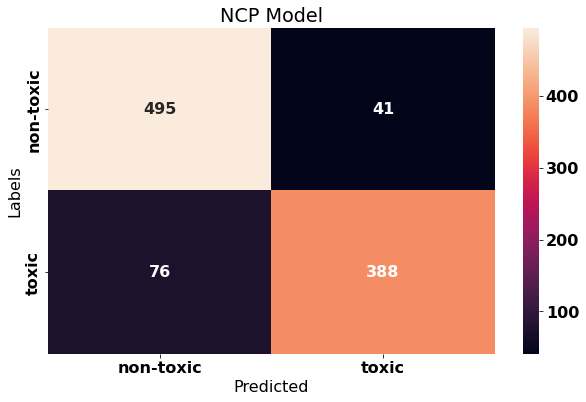

In [23]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd 
from sklearn.metrics import confusion_matrix

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)
pred = np.array([model.predict(test_folds[5][0]) > 0.5], dtype=int).ravel()
cm = confusion_matrix(test_folds[5][1].values, pred)
cm = pd.DataFrame(cm, range(2),range(2))
plt.figure(figsize = (10, 6))

sns.heatmap(cm,
            fmt = 'd',
            annot=True)


ax = plt.subplot()
ax.set_xlabel('Predicted')
ax.set_ylabel('Labels')
ax.xaxis.set_ticklabels(['non-toxic', 'toxic'])
ax.yaxis.set_ticklabels(['non-toxic', 'toxic'])
ax.set_title('NCP Model')
plt.show()

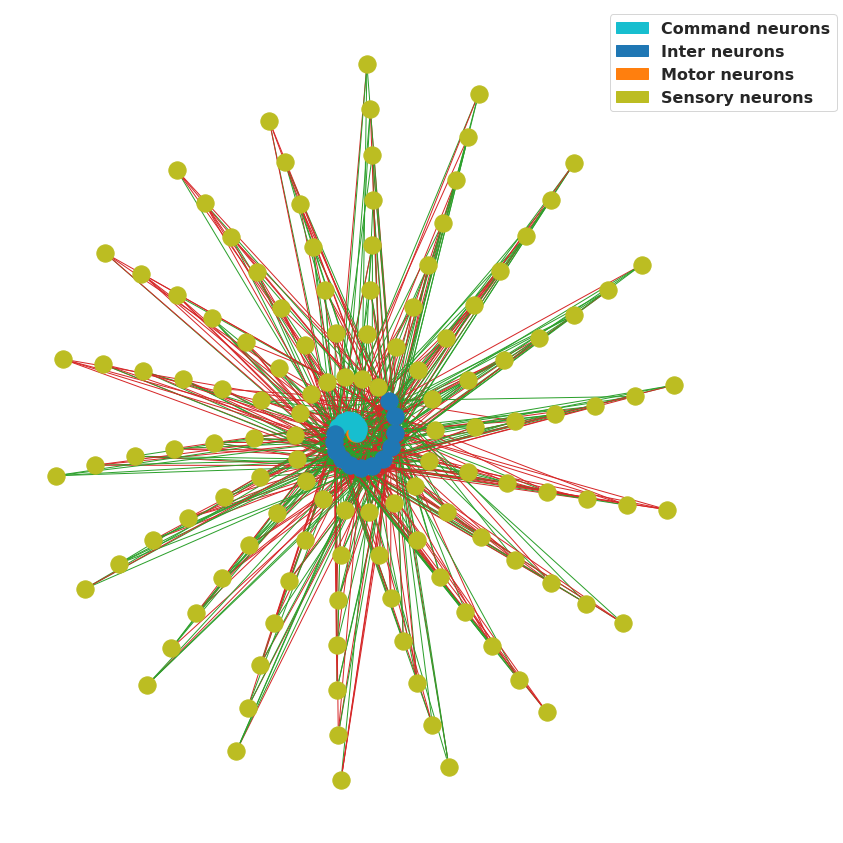

In [24]:
sns.set_style("white")
plt.figure(figsize=(12, 12))
legend_handles = ltc_cell.draw_graph(layout='spiral',neuron_colors={"command": "tab:cyan"})
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1, 1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()